# Newmark sliding block method in a spatial domain

© 2023 Exneyder A. Montoya-Araque, Silvana Montoya-Noguera, and Universidad EAFIT.

<!-- The methods shown in this notebook specifically refer to the [Fast Fourier Transform (FFT)](https://en.wikipedia.org/wiki/Fast_Fourier_transform), which is a specific algorithm to apply the [Discrete Fourier Transform (DFT)](https://en.wikipedia.org/wiki/Discrete_Fourier_transform). -->

This notebook can be interactively run in [Google - Colab](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_dynamics/blob/main/notebooks/pynewmarkdisp_dummy_example.ipynb).


## Required modules and global setup for plots

In [1]:
if 'google.colab' in str(get_ipython()):
    from google.colab import output
    output.enable_custom_widget_manager()
    %pip install ipympl &> ~/pip-log.txt
    %pip install pynewmarkdisp &> ~/pip-log.txt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pynewmarkdisp.newmark import direct_newmark, plot_newmark_integration
from pynewmarkdisp.infslope import factor_of_safety, get_ky
from pynewmarkdisp.spatial import *

%matplotlib widget

plt.style.use("default")
mpl.rcParams.update(
    {
        'interactive': False,
        "text.usetex": False,  # Use mathtext, not LaTeX
        "font.family": "cmr10",  # Use the Computer modern font
        "mathtext.fontset": "cm",
        "axes.formatter.use_mathtext": True,
        "axes.unicode_minus": False,
    }
)
html_setup = '<style> div.jupyter-widgets.widget-label {display: none;} </style>'

In [2]:
url = "https://raw.githubusercontent.com/eamontoyaa/data4testing/main/pynewmarkdisp/"

# Loading earthquake data
earthquake_record = pd.read_csv(f"{url}earthquake_data_simple.csv", sep=";")
g = 1.0  # It means, accel units are given in fractions of gravity
accel = np.array(earthquake_record["Acceleration"])
time = np.array(earthquake_record["Time"])

# Loading spatial data
dem, header = load_ascii_raster(f"{url}spatial_data_dummy_example/dem.asc")
slope, header = load_ascii_raster(f"{url}spatial_data_dummy_example/slope.asc")
zones, header = load_ascii_raster(f"{url}spatial_data_dummy_example/zones.asc")
depth, header = load_ascii_raster(f"{url}spatial_data_dummy_example/zmax.asc")
depth_w, header = load_ascii_raster(f"{url}spatial_data_dummy_example/depthwt.asc")

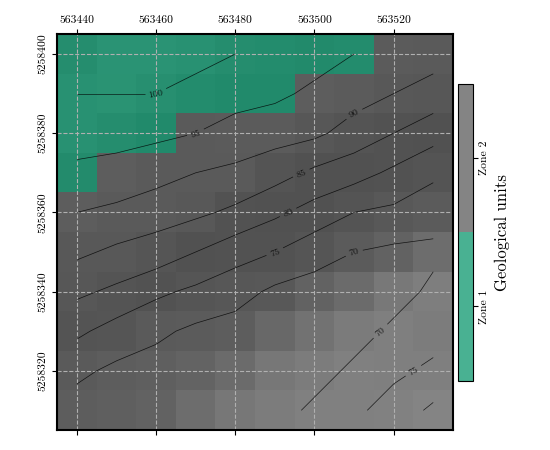

In [3]:
# General inputs
spat_ref = {
    'xy_lowerleft': (header["xllcorner"], header["yllcorner"]),
    'cell_size': header["cellsize"]
}
contours = np.arange(70, 105, 5)

# Geotechnical parameters of each geological zone
parameters = {  # Zone: frict_angle, cohesion, unit_weight
    1: (35, 3.5, 22),
    2: (31, 8, 22),
}
# Associating geotechnical parameters to each geological zone spatially and plotting
phi, c, gamma = map_zones(parameters, zones)
fig = plot_spatial_field(zones, dem, spat_ref=header, levels=contours,
                   title="Geological units", cmap='Dark2', discrete=True,
                   label=['Zone 1', 'Zone 2'], labelrot=90)
fig.show()

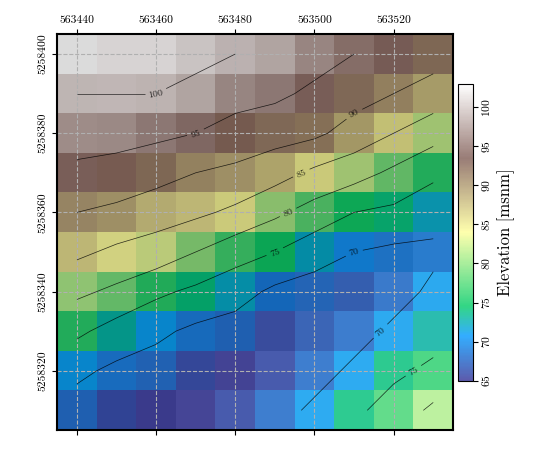

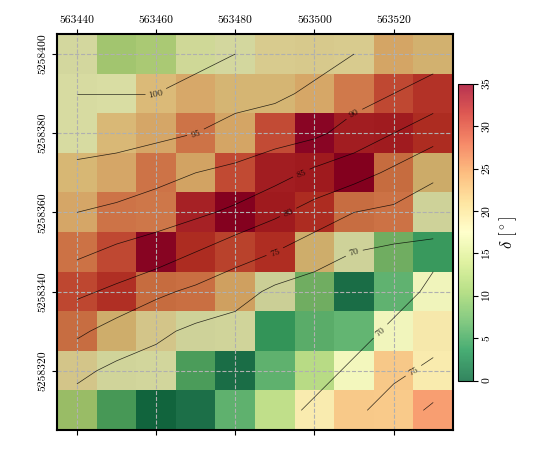

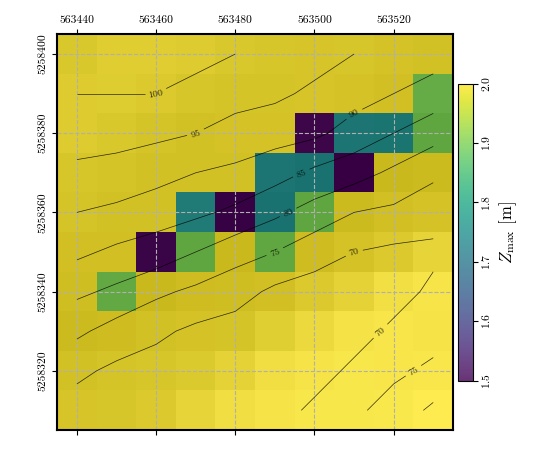

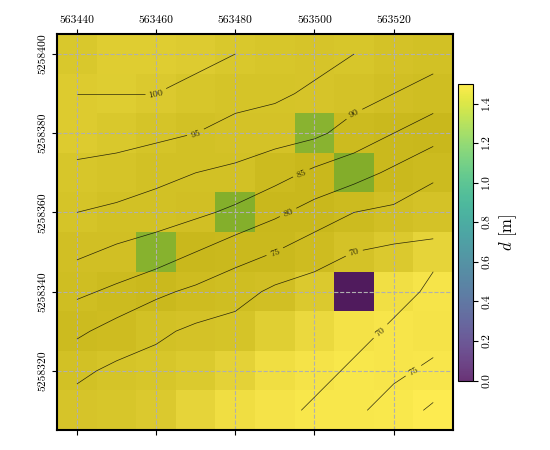

In [4]:
# plotting the digital elevation model (dem)
fig = plot_spatial_field(dem, dem, spat_ref=header, levels=contours, labelrot=90,
                         title="Elevation [msnm]", cmap='terrain', discrete=False)
fig.show()
# plotting the spatial distribution of slopes
fig = plot_spatial_field(slope, dem, spat_ref=header, levels=contours,
                         title="$\\delta\\ [^\\circ]$", cmap='RdYlGn_r', labelrot=90)
fig.show()
# plotting the spatial distribution of potential sliding mass depths
fig = plot_spatial_field(depth, dem, spat_ref=header, levels=contours,
                         title="$Z_\\mathrm{max}$ [m]", cmap='viridis', labelrot=90)
fig.show()
# plotting the spatial distribution of watertable depths
fig = plot_spatial_field(depth_w, dem, spat_ref=header, levels=contours,
                         title="$d$ [m]", cmap='viridis', labelrot=90)
fig.show()

In [5]:
factor_of_safety(depth=1, depth_w=1, slope=30, phi=27, c=5, gamma=17, ks=0)

1.562

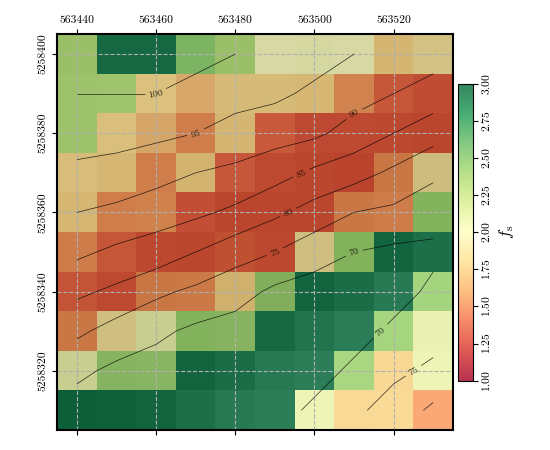

In [6]:
# Calculating the factor of safety and plotting its spatial distribution
fs = factor_of_safety(depth, depth_w, slope, phi, c, gamma, ks=0)
fig = plot_spatial_field(fs, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$f_\\mathrm{s}$", vmin=1.0, vmax=3.0, labelrot=90)
fig.show()

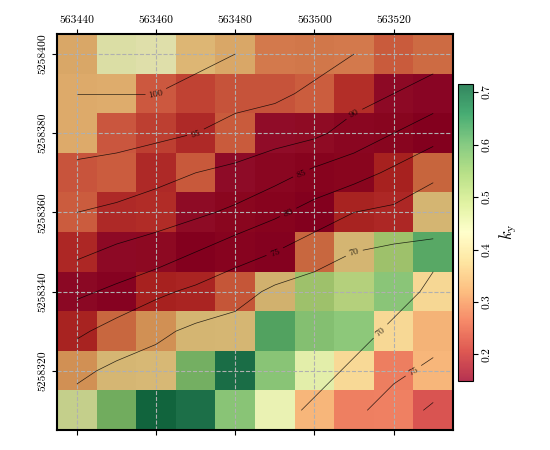

In [7]:
# Calculating the critical seismic coefficient and plotting its spatial distribution
ky = get_ky(depth, depth_w, slope, phi, c, gamma)
fig = plot_spatial_field(ky, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$k_\\mathrm{y}$", labelrot=90)
fig.show()

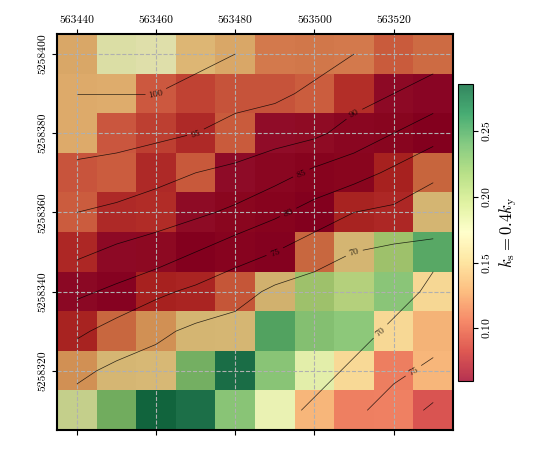

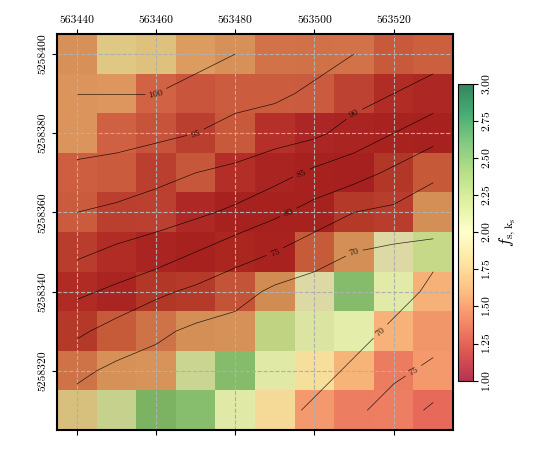

In [8]:
# Calculating factor of safety for pseudostatic conditions and plotting its spatial distribution
ks = 0.4 * ky
fig = plot_spatial_field(ks, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$k_\\mathrm{s} = 0.4 k_\\mathrm{y}$", labelrot=90)
fig.show()

fs_ks = factor_of_safety(depth, depth_w, slope, phi, c, gamma, ks=ks)
fig = plot_spatial_field(fs_ks, dem, spat_ref=header, levels=contours, cmap='RdYlGn',
                         title="$f_\\mathrm{s, k_\\mathrm{s}}$", vmin=1.0, vmax=3.0, labelrot=90)
fig.show()

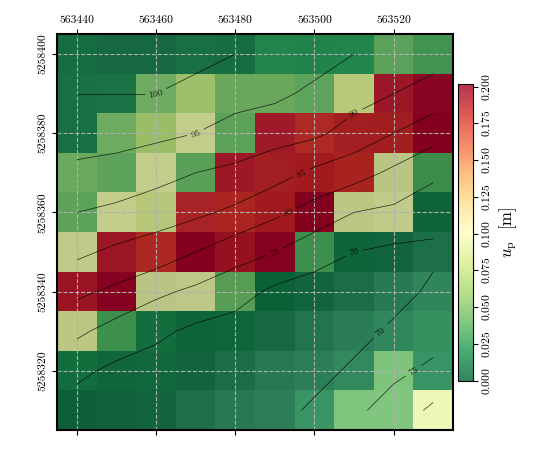

In [9]:
# Calculating permanent displacements and plotting its spatial distribution
permanent_disp = spatial_newmark(time, accel, ky, g)
fig = plot_spatial_field(permanent_disp, dem, spat_ref=header, levels=contours,
                         title="$u_\\mathrm{p}$  [m]", cmap='RdYlGn_r', labelrot=90)
fig.show()

2.0 95.0 26.6 1.52 0.2 0.09


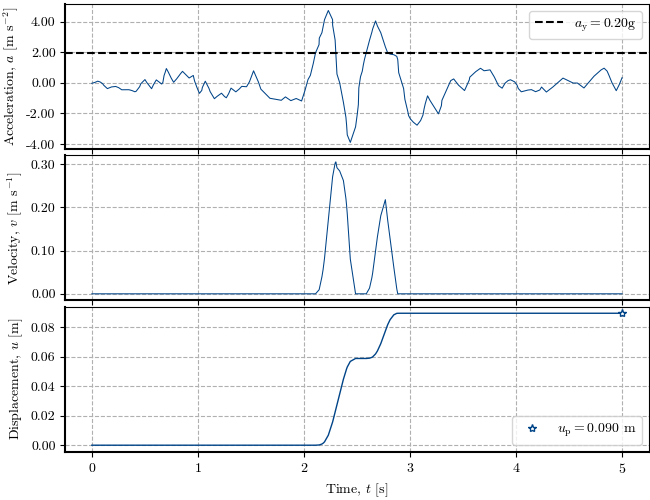

In [10]:
# Verification of the Direct Newmark Method at one cell
cell = (2, 3)
print(zones[cell], dem[cell], slope[cell], fs[cell], ky[cell], permanent_disp[cell])
newmark_str = verify_newmark_at_cell(
    cell, time, accel, g, depth, depth_w, slope, phi, c, gamma)
fig = plot_newmark_integration(newmark_str)
fig.show()

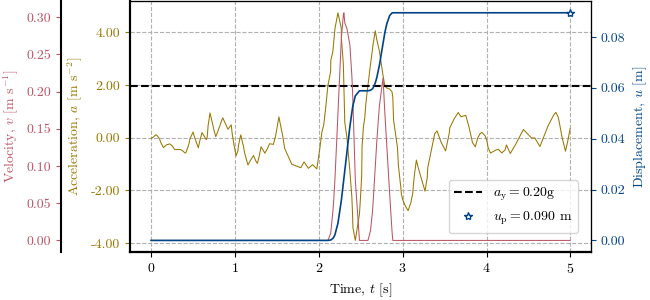

In [11]:
# Verification of the Direct Newmark Method at one cell
fig = plot_newmark_integration(newmark_str, True)
fig.show()